In [43]:
# Importing the Image

import math
import rasterio
import matplotlib.pyplot as plt

In [44]:
image_file = "20180831_181344_0f49_3B_AnalyticMS_DN.tif"
sat_data = rasterio.open(image_file)

In [45]:
# calculating the dimensions of the image on earth in metres

width_in_projected_units = sat_data.bounds.right - sat_data.bounds.left
height_in_projected_units = sat_data.bounds.top - sat_data.bounds.bottom

In [46]:
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

Width: 25149.0, Height: 12699.0


In [47]:
print("Rows: {}, Columns: {}".format(sat_data.height, sat_data.width))

Rows: 4233, Columns: 8383


In [48]:
# Converting the pixel co-ordinates to longitudes and latitudes
# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = sat_data.height - 1
col_max = sat_data.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = sat_data.transform * (row_min, col_min)
botright = sat_data.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (565866.0, 4140792.0)
Bottom right corner coordinates: (578562.0, 4115646.0)


In [49]:
# Bands: The image that we are inspecting is a multispectral image consisting of 4 bands int he order B,G,R,N where N stands for near infrared.each band is stored as a numpy array.

In [50]:
print(sat_data.count)

# sequence of band indexes
print(sat_data.indexes)

4
(1, 2, 3, 4)


In [51]:
# Visualising the Satellite Imagery - We will use matplotlib to visualise the image since it essentially consists of arrays.

In [52]:
# Load the 4 bands into 2d arrays - recall that we previously learned PlanetScope band order is BGRN.
b, g, r, n = sat_data.read()

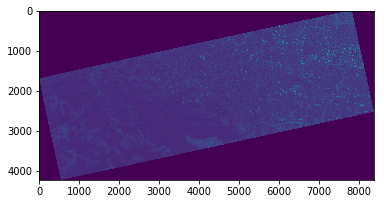

In [53]:
# Displaying the blue band.

fig = plt.imshow(b)
plt.show()

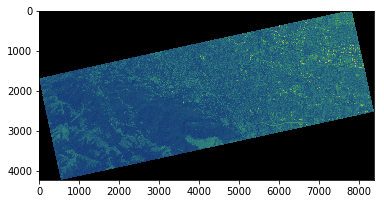

In [54]:
# Displaying the green band.

fig = plt.imshow(g)
fig.set_cmap('gist_earth')
plt.show()

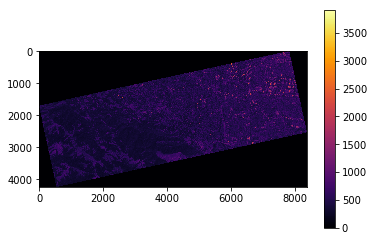

In [55]:
# Displaying the red band.

fig = plt.imshow(r)
fig.set_cmap('inferno')
plt.colorbar()
plt.show()

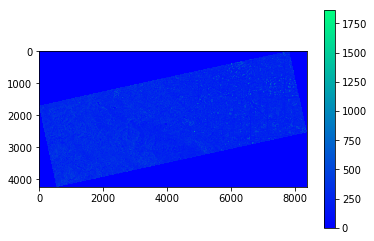

In [56]:
# Displaying the infrared band.

fig = plt.imshow(n)
fig.set_cmap('winter')
plt.colorbar()
plt.show()

In [25]:
### Vegetation Index calculation from Satellite Imagery 
# most widely used index to measure vegetation is the Normalized Difference Vegetation Index (NDVI)

In [57]:
import rasterio
import numpy
import matplotlib.pyplot as plt

In [58]:
filename = '20180831_181344_0f49_3B_AnalyticMS_DN.tif'
with rasterio.open(filename) as src:
    band_red = src.read(3)
with rasterio.open(filename) as src:
    band_nir = src.read(4)

In [59]:
# Calculating NDVI
# Do not display error when divided by zero 

numpy.seterr(divide='ignore', invalid='ignore')

# NDVI 
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [60]:
print(numpy.nanmin(ndvi)) 
print(numpy.nanmax(ndvi))

-0.9032581453634085
1.0


In [61]:
# get the metadata of original GeoTIFF:
meta = src.meta
print(meta)

# get the dtype of our NDVI array:
ndvi_dtype = ndvi.dtype
print(ndvi_dtype)

# set the source metadata as kwargs we'll use to write the new data:
kwargs = meta

# update the 'dtype' value to match our NDVI array's dtype:
kwargs.update(dtype=ndvi_dtype)

# update the 'count' value since our output will no longer be a 4-band image:
kwargs.update(count=1)

# Finally, use rasterio to write new raster file 'data/ndvi.tif':
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write(ndvi, 1)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 8383, 'height': 4233, 'count': 4, 'crs': CRS.from_dict(init='epsg:32610'), 'transform': Affine(3.0, 0.0, 565866.0,
       0.0, -3.0, 4140792.0)}
float64


In [62]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

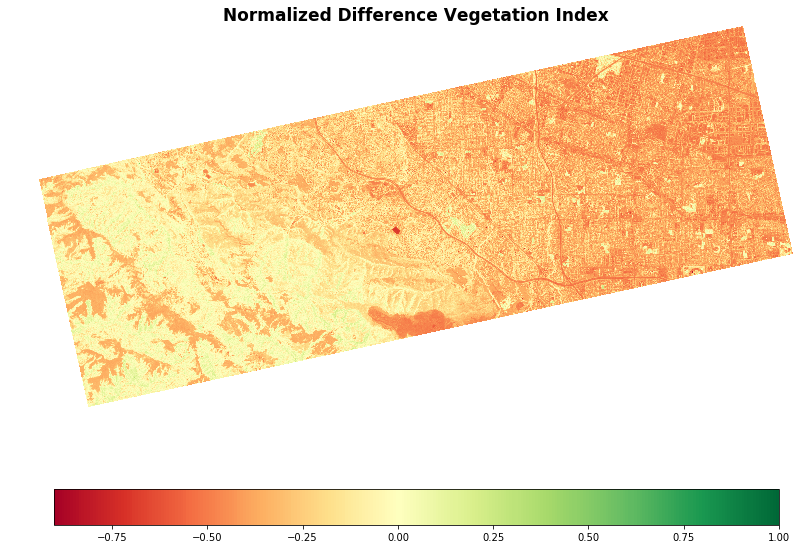

In [67]:
# Set min/max values from NDVI range for image

min=numpy.nanmin(ndvi)
max=numpy.nanmax(ndvi)

# Set our custom midpoint for most effective NDVI analysis
mid=0.0

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn 
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndvi, cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels 
ax.axis('off')

# Set a title 
ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

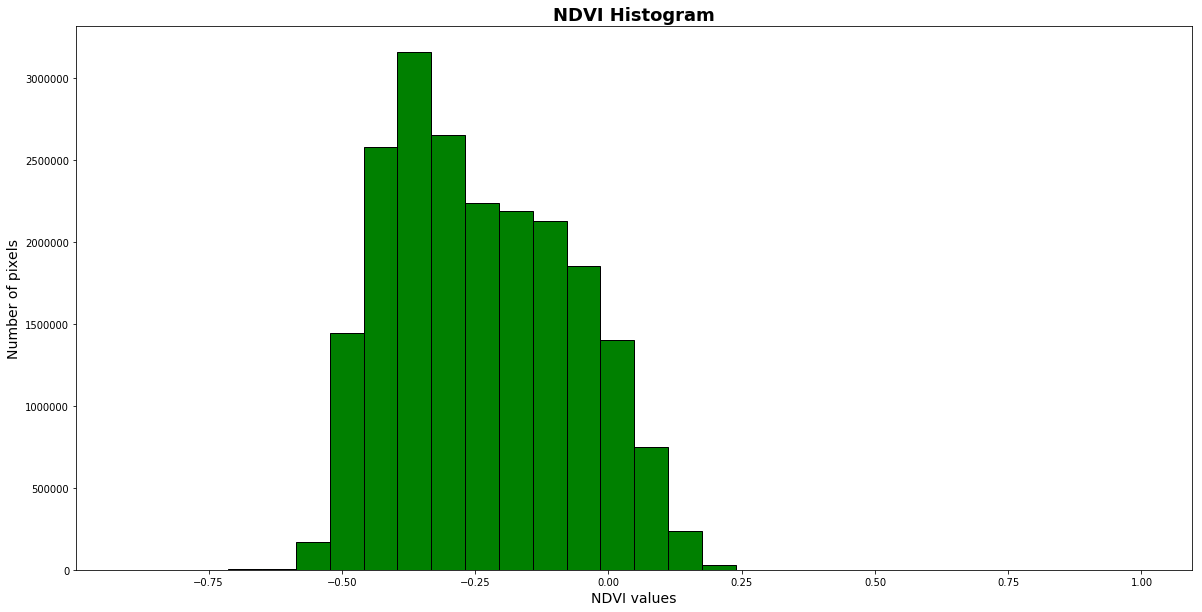

In [64]:
# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = ndvi[~numpy.isnan(ndvi)]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
#fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()